# PEAK3 Modelling

## Initialisation

In [1]:
from models.ModelBuilder import ModelBuilder
from models.Reaction import Reaction
from models.ReactionArchtype import ReactionArchtype
from models.ArchtypeCollections import *
from models.Utils import * 

import matplotlib.pyplot as plt
import roadrunner
import numpy as np
import pandas as pd

## Basic Model between 14-3-3 and Grb2

In [2]:
model = ModelBuilder('PEAK3_Simple_1')
model.add_reaction(Reaction(mass_action_21, ('PEAK3', 'Grb2'), ('PEAK3_Grb2',)))
model.add_reaction(Reaction(mass_action_21, ('PEAK3', 'Four'), ('PEAK3_Four',)))
model.precompile()


In [ ]:
print(model.get_antimony_model())

In [ ]:
model.simulate(0, 100, 100)
model.plot()

In [ ]:
sbml = model.get_sbml_model()
rr = roadrunner.RoadRunner(sbml)

states = model.get_all_variables_keys()
custom_states = model.get_custom_variable_keys()
sim_states = ['time'] + states
res = rr.simulate(0, 180, 180, selections=sim_states)

### VISUALISATION

observable_states = ['PEAK3', 'PEAK3_Four', 'Four']

for state in observable_states:
    plt.plot(res['time'], res[f'{state}'], label=state)

plt.legend()
plt.grid()
plt.show()


observable_states_2 = ['PEAK3', 'Grb2', 'PEAK3_Grb2']

for state in observable_states_2:
    plt.plot(res['time'], res[f'{state}'], label=state)
    
plt.legend()
plt.grid()
plt.show()

## Replication of Honours Model 2020

### Direct SBML Import from TXTBC File 

In [ ]:
# load sbml file from the path: src\models\examples\peak3\peak3-honours-sbml.xml without using ModelBuilder

rr = roadrunner.RoadRunner('C:\Github\\new-peak-project\src\models\examples\peak3\peak3-honours-sbml-older.xml')

# simulate the model

sim_data = rr.simulate(0, 5000 + 60 * 24, 180)
# visualise the named array 

# plt.plot(sim_data[0], sim_data[2], label='PEAK3')

print(sim_data.colnames)

for state in sim_data.colnames:
    if state == 'time':
        continue
    plt.plot(sim_data['time'], sim_data[state], label=state)
    
# only plot the later part of the simulation
plt.xlim(5000, 5000 + 60 * 24)
# plt.legend()
plt.grid()
plt.show()


In [100]:
# load in parameter set from a txt file 
# C:\Github\new-peak-project\src\models\examples\peak3\Finalparamset-NoFix.txt

# param_set = pd.read_csv('C:\Github\\new-peak-project\src\models\examples\peak3\Finalparamset-NoFix.txt', sep='\t', header=None)

# open txt file 

# all_param_sets_processed = []

# with open('C:\Github\\new-peak-project\src\models\examples\peak3\Finalparamset-NoFix.txt') as f:
#     lines = f.readlines()
#     all_param_set = [line.split('\t') for line in lines]
#     for param_set in all_param_set:
#         # remove the \n character 
#         # print(param_set)
#         param_set_real = param_set[0]
#         param_set_real = param_set_real.replace('\n', '')
        
#         param_set_individual = param_set_real.split('   ')
#         # remove the first element
#         param_set_individual.pop(0)
#         # print(param_set_individual)
#         # convert each element to float
#         param_set_individual = [float(i) for i in param_set_individual]
#         # remove the 17th element
#         param_set_individual.pop(16)
#         # print(param_set_individual)
#         # print(len(param_set_individual))    
#         all_param_sets_processed.append(param_set_individual)

# param_sets_df = pd.DataFrame(all_param_sets_processed)
        
    
# print(param_set)

In [ ]:
all_param_sets_processed = []

with open('C:\Github\\new-peak-project\src\models\examples\peak3\Finalparamset.txt') as f:
    lines = f.readlines()
    all_param_set = [line.split('\t') for line in lines]
    for param_set in all_param_set:
        # remove the \n character 
        # print(param_set)
        param_set_real = param_set[0]
        param_set_real = param_set_real.replace('\n', '')
        
        param_set_individual = param_set_real.split('   ')
        # remove the first five elements
        param_set_individual = param_set_individual[5:]
        # print(param_set_individual)
        # convert each element to float
        param_set_individual = [float(i) for i in param_set_individual]
        # remove the 17th element
        # print(param_set_individual)
        # print(len(param_set_individual))   
        # break 
        all_param_sets_processed.append(param_set_individual)

param_sets_df = pd.DataFrame(all_param_sets_processed)

In [ ]:
# get parameter names from the sbml file

param_names = rr.model.getGlobalParameterIds()

altered_params = param_names[:65]

print(altered_params)
# print(len(first_72_params))

# print(len(param_names))

In [ ]:
# get the first row from the param_sets_df

first_param_set = param_sets_df.iloc[4]

for i, param in enumerate(first_param_set):
    rr.model[altered_params[i]] = param
    
# check if the parameters have been set correctly

for i, param in enumerate(first_param_set):
    print(rr.model[altered_params[i]])
    
# simulate the model with the new parameters

sim_data = rr.simulate(0, 5000 + 60 * 24, 5000 + 50 * 24)

for state in sim_data.colnames:
    if state == 'time':
        continue
    plt.plot(sim_data['time'], sim_data[state], label=state)
    
# only plot the later part of the simulation
# plt.xlim(5000, 5000 + 60 * 24)
# plt.legend()
plt.grid()
plt.show()

In [ ]:
# extra values 

assignment_states = ['boundASAP1', 'boundGrb2']

# Convert to Pandas DataFrame
df = pd.DataFrame(sim_data, columns=sim_data.colnames)

# Get assignment rule names (parameters that are computed dynamically)
assignment_names = rr.getAssignmentRuleIds()

print("Assignment Rules Found:", assignment_names)

# Extract assignment values dynamically at each time step
assignment_values = {name: [] for name in assignment_names}

# Evaluate assignment rules at each time step
for i in range(len(df)):
    rr.time = df["time"][i]  # Set RoadRunner time
    for name in assignment_names:
        assignment_values[name].append(rr.getValue(name))  # Get computed assignment value

# Convert assignment data to DataFrame
df_assignments = pd.DataFrame(assignment_values, index=df["time"])

# Plot assignment rule values over time
plt.figure(figsize=(10, 6))
for col in df_assignments.columns:
    plt.plot(df_assignments.index, df_assignments[col], label=col)

plt.xlabel("Time")
plt.ylabel("Assignment Value")
plt.title("Assignment Rule Values Over Time")
# only plot the later part of the simulation
plt.xlim(5000, 5000 + 60 * 3)
# plt.legend()
plt.grid()
plt.show()

## Simplified Honours Model SFK/Grb2/ASAP1 Axis

#### Defining Reactions

In [3]:
weak_stim = create_archtype_michaelis_menten(stimulator_weak=1)
weak_stim_2 = create_archtype_michaelis_menten(stimulator_weak=2)
normal_stim = create_archtype_michaelis_menten(stimulators=1)

## Main Reactions 

EGFR_Forward = Reaction(michaelis_menten_stim, ('EGFR',), ('EGFR_pY',), extra_states=('egf',))
EGFR_Reverse = Reaction(michaelis_menten, ('EGFR_pY',), ('EGFR',))
EGFR_Forward_aSFK = Reaction(weak_stim_2, ('EGFR',), ('EGFR_pY',), extra_states=('egf', 'SFK_a'))

SFK_Forward = Reaction(michaelis_menten_stim, ('SFK',), ('SFK_a',), extra_states=('EGFR_pY',))
SFK_Reverse = Reaction(michaelis_menten, ('SFK_a',), ('SFK',))

PEAK3_Grb2 = Reaction(mass_action_21, ('PEAK3pY', 'Grb2'), ('PEAK3pY_Grb2',))
Grb2_ASAP1 = Reaction(mass_action_21, ('Grb2', 'ASAP1'), ('Grb2_ASAP1',))

PEAK3__Grb2_ASAP1 = Reaction(mass_action_21, ('PEAK3pY_Grb2', 'ASAP1'), ('PEAK3pY_Grb2_ASAP1',))
PEAK3_Grb2__ASAP1 = Reaction(mass_action_21, ('PEAK3pY', 'Grb2_ASAP1'), ('PEAK3pY_Grb2_ASAP1',)) 

PEAK3_Forward = Reaction(normal_stim, ('PEAK3',), ('PEAK3pY',), 'core1', extra_states=('SFK_a',))
PEAK3_Reverse = Reaction(michaelis_menten, ('PEAK3pY',), ('PEAK3',), 'core1b')
PEAK3_Reverse_PTPN12 = Reaction(normal_stim, ('PEAK3pY',), ('PEAK3',), 'core1b2', extra_states=('PTPN12_a',))

PTPN12_Forward_pEGFR = Reaction(michaelis_menten_stim, ('PTPN12',), ('PTPN12_a',), extra_states=('EGFR_pY',))
PTPN12_Forward_Alpha = Reaction(michaelis_menten_stim, ('PTPN12',), ('PTPN12_a',), extra_states=('Alpha',))
PTPN12_Reverse = Reaction(michaelis_menten, ('PTPN12_a',), ('PTPN12',))

## Custom Variables
egf_piecewise = (0, 1440.1, 8.33, 'egf')
alpha_piecewise = (0, 1440.1, 50, 'Alpha')
total_bound_PEAK3pY = ('total_bound_PEAK3pY', 'total_bound_PEAK3pY := PEAK3pY_Grb2 + PEAK3pY_Grb2_ASAP1')
total_bound_Grb2 = ('total_bound_Grb2', 'total_bound_Grb2 := PEAK3pY_Grb2 + PEAK3pY_Grb2_ASAP1')
total_bound_ASAP1 = ('total_bound_ASAP1', 'total_bound_ASAP1 := PEAK3pY_Grb2_ASAP1')
total_Grb2 = ('total_Grb2', 'total_Grb2 := Grb2 + Grb2_ASAP1 + PEAK3pY_Grb2 + PEAK3pY_Grb2_ASAP1')
total_PEAK3pY = ('total_PEAK3pY', 'total_PEAK3pY := PEAK3pY + PEAK3pY_Grb2 + PEAK3pY_Grb2_ASAP1')
total_ASAP1 = ('total_ASAP1', 'total_ASAP1 := ASAP1 + Grb2_ASAP1 + PEAK3pY_Grb2_ASAP1')

piecewise_functions = [egf_piecewise, alpha_piecewise]
all_custom_variables = [total_bound_PEAK3pY, total_bound_Grb2, total_bound_ASAP1, total_Grb2, total_PEAK3pY, total_ASAP1]

def build_model(model_name, reactions, piecewise_functions, custom_variables, init_species):
    model = ModelBuilder(model_name)
    for reaction in reactions:
        model.add_reaction(reaction)
    for f in piecewise_functions: 
        model.add_simple_piecewise(f[0], f[1], f[2], f[3])
    for custom_variable in custom_variables:
        model.add_custom_variables(custom_variable[0], custom_variable[1])

    for s in init_species:
        model.add_enforce_state_value(s, 100)

    # ensure the rest of the species are set to 0
    remaining_species = [
        s for s in model.get_all_variables_keys() if s not in init_species]
    for s in remaining_species:
        model.add_enforce_state_value(s, 0)
        
    model.precompile()
    return model

#### Model A

In [4]:
model_A_reactions = [EGFR_Forward, EGFR_Reverse,
                     SFK_Forward, SFK_Reverse,
                     PEAK3_Forward, PEAK3_Reverse,
                     PEAK3_Grb2, Grb2_ASAP1, PEAK3__Grb2_ASAP1, PEAK3_Grb2__ASAP1]

peak3_model_A = build_model('PEAK3_Model_A', model_A_reactions, piecewise_functions, all_custom_variables, ['EGFR', 'SFK', 'PEAK3', 'Grb2', 'ASAP1'])    

### Edit Model Parameters

peak3_model_A.set_parameter('core1b_Vmax', 100)

#### Model B

In [5]:
model_B_reactions = [EGFR_Forward, EGFR_Reverse,
                     SFK_Forward, SFK_Reverse,
                     PTPN12_Forward_pEGFR, PTPN12_Reverse,
                     PEAK3_Forward, PEAK3_Reverse,
                     PEAK3_Grb2, Grb2_ASAP1, PEAK3__Grb2_ASAP1, PEAK3_Grb2__ASAP1]

peak3_model_B = build_model('PEAK3_Model_B', model_B_reactions, piecewise_functions, all_custom_variables, ['EGFR', 'SFK', 'PEAK3', 'Grb2', 'ASAP1', 'PTPN12'])

#### Model C

In [6]:
model_C_reactions = [EGFR_Forward_aSFK, EGFR_Reverse,
                     SFK_Forward, SFK_Reverse,
                     PTPN12_Forward_Alpha, PTPN12_Reverse, # PTPN12 is not activated by pEGFR
                     PEAK3_Forward, PEAK3_Reverse_PTPN12,
                     PEAK3_Grb2, Grb2_ASAP1, PEAK3__Grb2_ASAP1, PEAK3_Grb2__ASAP1]

peak3_model_C = build_model('PEAK3_Model_C', model_C_reactions, piecewise_functions, all_custom_variables, ['EGFR', 'SFK', 'PEAK3', 'Grb2', 'ASAP1', 'PTPN12'])

### Importing Experimental Data

In [7]:
from optimisation.ExpDataLoader import ExpDataLoader
import numpy as np

ex = ExpDataLoader()
ex.load_data('C:\Github\\new-peak-project\src\data\peak3_data_grb2_asap1.csv', delimiter='\t')

### Randomisation Experiments

In [42]:
model = peak3_model_C
param_perturbation_range = [0.1, 10]
n = 100

# grab all parameters from the model
init_params = model.parameters 
perturbation_set = [] 
for _ in range(n):
    perturbed_params = {}
    for k, v in init_params.items():
        perturbed_params[k] = np.random.uniform(v * param_perturbation_range[0], v * param_perturbation_range[1])
    perturbation_set.append(perturbed_params)
    
perturbation_set_df = pd.DataFrame(perturbation_set)

perturbation_set_df


,J0_Km,J0_Vmax,J0_Kw0,J0_Kw1,J1_Km,J1_Vmax,J2_Km,J2_Vmax,J3_Km,J3_Vmax,...,core1b2_Vmax,core1b2_Ka0,J8_ka,J8_kd,J9_ka,J9_kd,J10_ka,J10_kd,J11_ka,J11_kd
0,927.744349,6.145140,0.321083,0.890886,12.255047,15.136790,325.497452,57.519912,466.106973,44.407065,...,8.511391,0.077827,0.006886,0.080728,0.009266,0.093550,0.003891,0.045854,0.007308,0.052155
1,845.316133,4.103100,0.815790,0.200561,905.402664,33.715921,413.672328,86.248668,758.878254,76.993535,...,9.752793,0.051053,0.007222,0.011376,0.002992,0.094015,0.007559,0.069109,0.007906,0.017403
2,173.967959,5.593620,0.755299,0.378559,777.872500,10.762679,105.197596,8.530722,504.250872,98.048204,...,2.685799,0.049288,0.001239,0.097574,0.007734,0.078104,0.006810,0.057182,0.005673,0.007337
3,319.533414,5.025529,0.831615,0.823733,566.838152,6.703142,694.532174,38.230457,889.016796,71.495142,...,5.702929,0.073375,0.003055,0.042295,0.007002,0.035373,0.004227,0.078944,0.002167,0.030894
4,312.079663,8.297057,0.174169,0.473606,995.323864,91.964236,190.706160,74.036142,88.845214,14.523379,...,0.428733,0.099398,0.002409,0.003973,0.002014,0.088427,0.000508,0.016640,0.008882,0.038805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,973.936135,1.851579,0.804511,0.785530,273.318081,83.220130,620.183095,14.979913,892.486541,4.784696,...,5.805853,0.073000,0.008221,0.050632,0.005869,0.026406,0.005638,0.029192,0.009760,0.078364
96,869.479182,7.149345,0.291437,0.200729,188.461696,4.030845,935.152414,77.256261,893.575449,82.976184,...,6.869674,0.007950,0.003638,0.027673,0.008496,0.087141,0.007837,0.067649,0.005282,0.083847
97,899.662913,0.308397,0.156849,0.984006,184.072399,16.140363,874.930027,81.595388,365.074867,34.404383,...,7.938461,0.095341,0.005733,0.024864,0.005991,0.067823,0.006383,0.095283,0.007308,0.085134
98,371.844370,1.245225,0.775663,0.141900,478.949351,54.079008,796.820197,86.772083,493.945586,51.220943,...,9.237625,0.037572,0.001448,0.097927,0.001244,0.006656,0.003155,0.012521,0.008893,0.010480


Error rate: 0.44
(56, 1620)


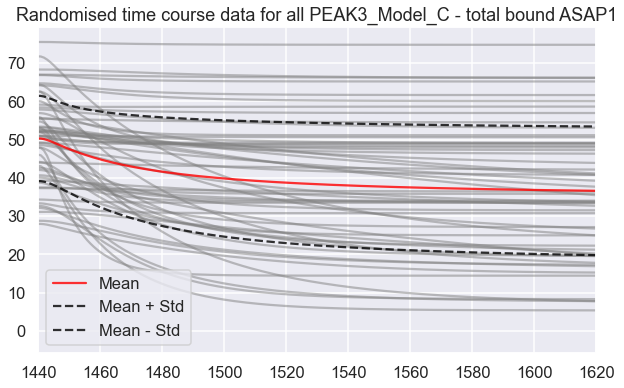

In [46]:

all_res_ASAP1 = []
all_res_Grb2 = []
n_errors = 0
# for each row in the perturbation set, simulate the model and save the results
for i in range(n):
    # for all parameters in the i-th row, set the parameter in the model
    for k, v in perturbation_set_df.iloc[i].items():
        model.set_parameter(k, v)
    
    # create a rr instance from the model and simulate
    try: 
        rr = roadrunner.RoadRunner(model.get_sbml_model())
        states = model.get_all_variables_keys()
        sim_data = rr.simulate(0, 1440 + 180, 1440 + 180, selections=['time'] + states)
        total_ASAP1 = sim_data['total_bound_ASAP1']
        total_Grb2 = sim_data['total_bound_Grb2']
        all_res_ASAP1.append(total_ASAP1)
        all_res_Grb2.append(total_Grb2)
    except Exception as e:
        # print(e)
        n_errors += 1
    
error_rate = n_errors / n
print(f'Error rate: {error_rate}')
model.precompile()
rr = roadrunner.RoadRunner(model.get_sbml_model())
states = model.get_all_variables_keys()
res = rr.simulate(0, 1440 + 180, 1440 + 180, selections=['time'] + states)

time_course_data = all_res_ASAP1
time_course_data = np.array(time_course_data)
print(time_course_data.shape)

import seaborn as sns

sns.set_context('talk')
plt.figure(figsize=(10, 6))

plt.title(f'Randomised time course data for all {model.name} - total bound ASAP1')
plt.plot(res['time'], time_course_data.T, color='gray', alpha=0.5)
plt.plot(res['time'], time_course_data.mean(axis=0), color='red', label='Mean', alpha=0.8)
plt.plot(res['time'], time_course_data.mean(axis=0) + time_course_data.std(axis=0), color='black', label='Mean + Std', alpha=0.8, linestyle='--')
plt.plot(res['time'], time_course_data.mean(axis=0) - time_course_data.std(axis=0), color='black', label='Mean - Std', alpha=0.8, linestyle='--')
plt.xlim(1440, 1440+180)
plt.legend()
plt.show()
 

(56, 1620)


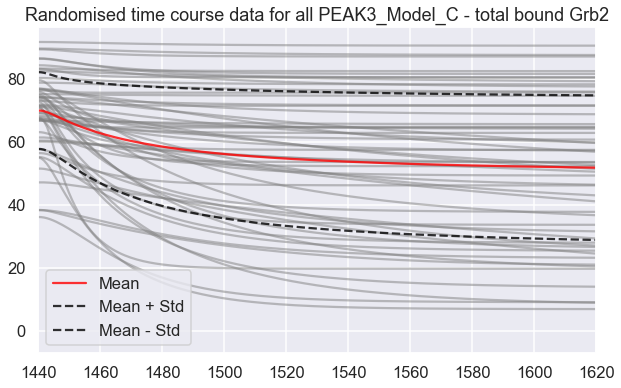

In [45]:
time_course_data = all_res_Grb2
time_course_data = np.array(time_course_data)
print(time_course_data.shape)

import seaborn as sns

sns.set_context('talk')
plt.figure(figsize=(10, 6))

plt.title(f'Randomised time course data for all {model.name} - total bound Grb2')
plt.plot(res['time'], time_course_data.T, color='gray', alpha=0.5)
plt.plot(res['time'], time_course_data.mean(axis=0), color='red', label='Mean', alpha=0.8)
plt.plot(res['time'], time_course_data.mean(axis=0) + time_course_data.std(axis=0), color='black', label='Mean + Std', alpha=0.8, linestyle='--')
plt.plot(res['time'], time_course_data.mean(axis=0) - time_course_data.std(axis=0), color='black', label='Mean - Std', alpha=0.8, linestyle='--')
plt.xlim(1440, 1440+180)
plt.legend()
plt.show()

### Basic Model Calibration

### Visualise all specie values over time for one model

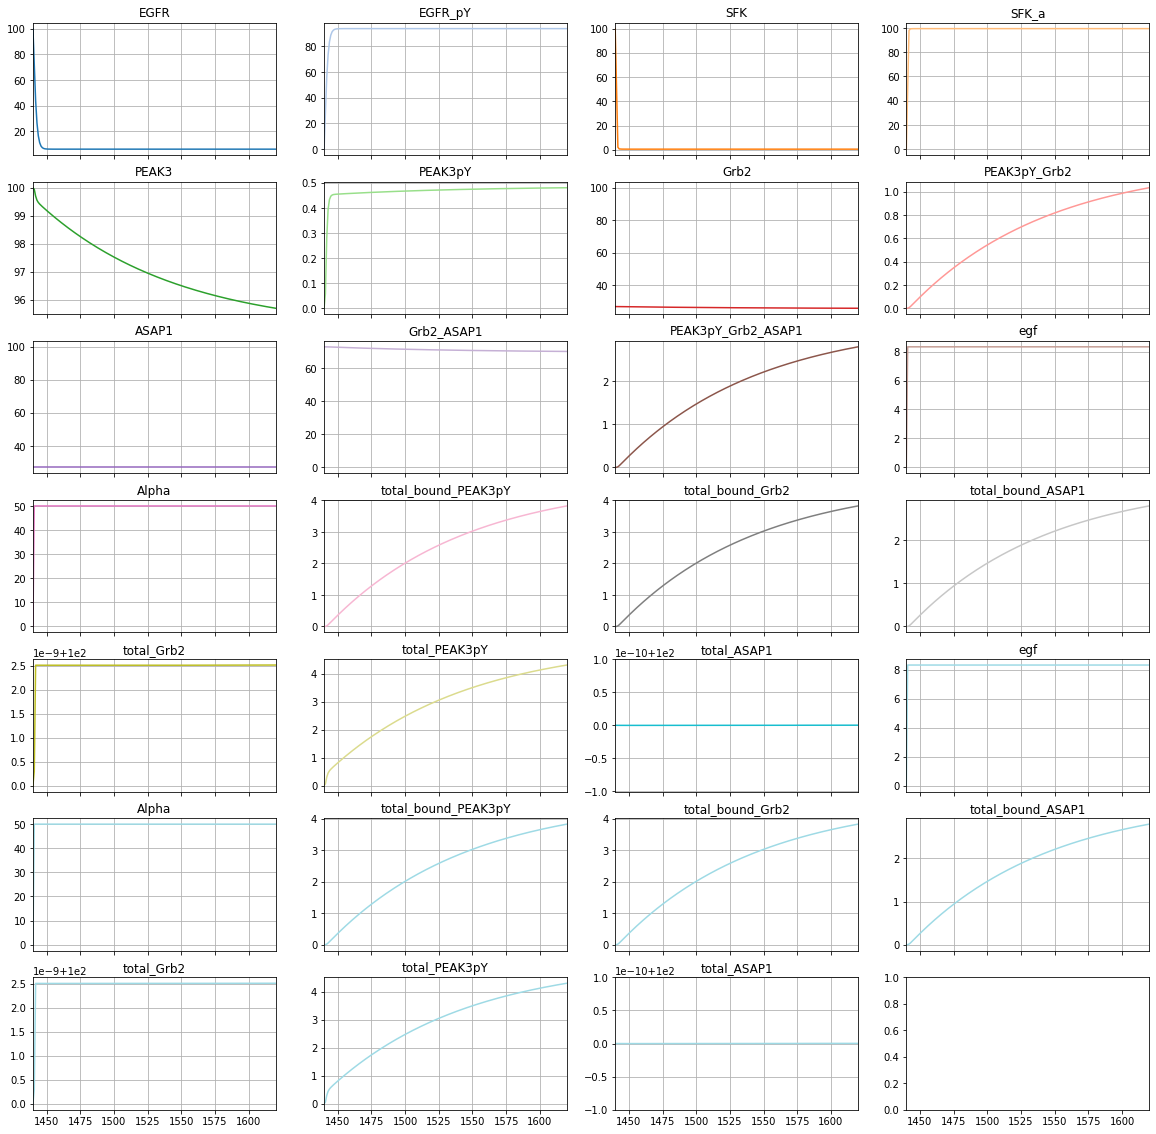

In [ ]:
model = peak3_model_A 
plot_range = (1440, 1440+180)  # alternatively, (1440, 1440+180)

sbml = model.get_sbml_model()
rr = roadrunner.RoadRunner(sbml)
states = model.get_all_variables_keys()
custom_states = model.get_custom_variable_keys()
sim_states = ['time'] + states
res = rr.simulate(0, 1440+180, 1440+180, selections=sim_states)

cols = 4  # number of columns in the plot
rows = len(states) // cols + 1 if len(states) // 4 != 0 else len(states) // 4
fig, axs = plt.subplots(rows, cols, figsize=(20, 20), sharex=True)

# create a colour palette for the plot
palette = plt.get_cmap('tab20')

for i, state in enumerate(states):
    ax = axs[i // cols, i % cols]
    ax.plot(res['time'], res[state], color=palette(i))
    ax.set_title(state)
    ax.set_xlim(plot_range[0], plot_range[1])
    ax.grid()
plt.show()

### Visualise a set of species in one model

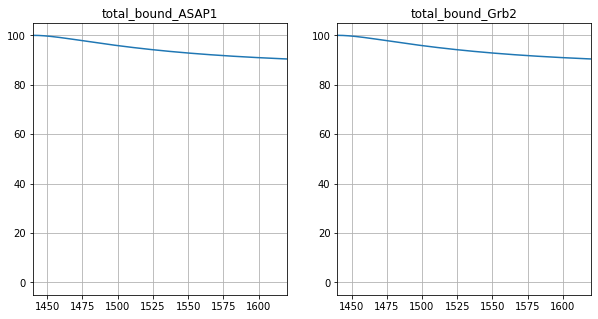

In [33]:
custom_states_to_print = ['total_bound_ASAP1', 'total_bound_Grb2']
model = peak3_model_C
plot_range = (1440, 1440+180)  # alternatively, (1440, 1440+180)

sbml = model.get_sbml_model()
rr = roadrunner.RoadRunner(sbml)
states = model.get_all_variables_keys()
custom_states = model.get_custom_variable_keys()
sim_states = ['time'] + states
res = rr.simulate(0, 1440+180, 1440+180, selections=sim_states)

# # normalised simulation results based on the 'stim_time' point for all states
# extracted_res = {}
# for c in res.colnames:
#     if c != 'time':
#         extracted_res_c = res[c] / res[c][1440] * 100
#         extracted_res[c] = extracted_res_c

# extracted_res['time'] = res['time']
# res = extracted_res

# create a multi-plot figure showing each custom state over time
cols = 2 # number of columns in the plot
rows = len(custom_states_to_print) // cols + 1 if len(custom_states_to_print) % 2 != 0 else len(custom_states_to_print) // 2
if rows < 2:
    fix, ax = plt.subplots(1, cols, figsize=(10, 5))
    for i, state in enumerate(custom_states_to_print):
        ax[i].plot(res['time'], res[state])
        ax[i].set_title(state)
        ax[i].set_xlim(plot_range[0], plot_range[1])
        ax[i].grid()
    plt.show()
else: 
    fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), sharex=True)

    for i, state in enumerate(custom_states_to_print):
        ax = axs[i // cols, i % cols]
        ax.plot(res['time'], res[state])
        ax.set_title(state)
        ax.set_xlim(plot_range[0], plot_range[1])
        ax.grid()
    
plt.show()

### Compare a set of species in multiple models

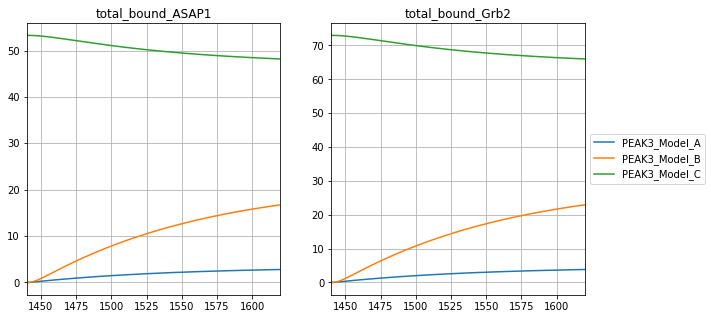

In [42]:
models_to_compare = [peak3_model_A, peak3_model_B, peak3_model_C]
species_to_compare = ['total_bound_ASAP1', 'total_bound_Grb2']
plot_range = (1440, 1440+180)  # alternatively, (1440, 1440+180)

# create a multi-plot figure showing each custom state over time
cols = 2 # number of columns in the plot
rows = len(species_to_compare) // cols + 1 if len(species_to_compare) % 2 != 0 else len(species_to_compare) // 2
if rows < 2:
    fix, ax = plt.subplots(1, cols, figsize=(10, 5))
    for i, state in enumerate(species_to_compare):
        for model in models_to_compare:
            sbml = model.get_sbml_model()
            rr = roadrunner.RoadRunner(sbml)
            states = model.get_all_variables_keys()
            custom_states = model.get_custom_variable_keys()
            sim_states = ['time'] + states
            res = rr.simulate(0, 1440+180, 1440+180, selections=sim_states)
            ax[i].plot(res['time'], res[state], label=model.name)
            ax[i].set_title(state)
            ax[i].set_xlim(plot_range[0], plot_range[1])
            ax[i].grid() 
else:
    fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5), sharex=True)

    for i, state in enumerate(species_to_compare):
        for j, model in enumerate(models_to_compare):
            ax = axs[i // cols, i % cols]
            sbml = model.get_sbml_model()
            rr = roadrunner.RoadRunner(sbml)
            states = model.get_all_variables_keys()
            custom_states = model.get_custom_variable_keys()
            sim_states = ['time'] + states
            res = rr.simulate(0, 1440+180, 1440+180, selections=sim_states)
            ax.plot(res['time'], res[state], label=model.name)
            ax.set_title(state)
            ax.set_xlim(plot_range[0], plot_range[1])
            ax.grid()

# set the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()